In [1]:
#!/usr/bin/env python
# coding: utf-8

In[1]:

Plotar o grÃ¡fico com o filtro 

In [2]:
import matplotlib.pyplot as plt
import os
import pandas as pd

In[2]:

In [3]:
class Sinal():
    """
    Esta classe foi construida como entrega do projeto da matÃ©ria "Analise de Sinais"
    O objetivo da classe Ã© permitir que calculemos a saÃ­da de um sistema SLIT, a partir
    de um filtro h[t] e entrada dada pelo sinal x[t].
    A saÃ­da y[t] filtrada do sistema serÃ¡ a convoluÃ§Ã£o de x[t] com h[t], denotada por 
    y[t] = x[t]*h[t]
    Foram impementados dois tipos de filtros: filtro da mÃ©dia e filtro gaussiano
    Ã‰ possÃ­vel utilizar todos os sinais presentes na pasta "sinais"
    """
    def __init__(self,
                nome_arquivo_entrada="",
                caminho="", 
                reverse=False):
        self.caminho = caminho
        self.nome_arquivo_entrada = nome_arquivo_entrada
        self.reverse = reverse
        self.lista_sinal = list()
    
    def informacoes_arquivo_entrada(self):
        if self.caminho != "" and self.nome_arquivo_entrada != "":
            arquivo = os.path.join(self.caminho, self.nome_arquivo_entrada)
        else:
            arquivo = self.nome_arquivo_entrada
        with open(arquivo, "r") as f:
            num_lines = 0
            vetor_entrada_sinais = list()
            for i, l in enumerate(f):
                # se nÃ£o Ã© uma linha em branco, adiciona na lista de sinais e conta o registro
                if l.strip():
                    vetor_entrada_sinais.append(float(l.strip()))
                    num_lines += 1

        # Se o usuario optar por inverter a sÃ©rie temporal dos dados
        if self.reverse:
            vetor_entrada_sinais.reverse()
        self.lista_sinal = vetor_entrada_sinais
        
        return(num_lines, vetor_entrada_sinais)
    def gera_filtro_media(self, valor_media):
        self.valor_media = valor_media
        filtro_h = list()

        # Se valor igual a 3, gera [1/3, 1/3, 1/3]
        for i in range(1, self.valor_media+1):
            filtro_h.append(1/self.valor_media)
        return filtro_h
    def gera_filtro_gaussiano(self, tamanho):
        self.tamanho = tamanho
        lista_filtro_gaussiano = list()
        linha = self.tamanho - 1
        soma_coef = 0

        # utilizado pra calcular cada valor do Triangulo de Pascal
        def coeficiente_binomial(linha, kaesimo):
            #linha! / (kesimo! * (linha - kesimo)!)
            def fatorial(numero):
                fatorial = 1
                while (numero > 0):
                    fatorial = fatorial * numero
                    numero -= 1
                    
                return fatorial
            n = fatorial(linha)
            k = fatorial(kaesimo)
            diferenca = linha - kaesimo
            diferenca = fatorial(diferenca)
            coef_binomial = n / (k * diferenca)
            return coef_binomial

        # Se gaussiano Ã© ordem n, extrai os valores referentes a linha n-1 do triÃ¢ngulo de pascal
        for i in range(linha+1):
            coef_binomial = coeficiente_binomial(linha,i)
            soma_coef = soma_coef + coef_binomial
            lista_filtro_gaussiano.append(coef_binomial)
        
        # divide cada valor da lista com o filtro gaussiano e divide pela some dos coeficientes da linha (n-1)
        for n in range(len(lista_filtro_gaussiano)):
            lista_filtro_gaussiano[n] = lista_filtro_gaussiano[n] / soma_coef
        
        return lista_filtro_gaussiano

    # FIltra o sinal pelo cÃ¡lculo da ConvoluÃ§Ã£o entre entrada e filtro
    def filtra_sinal(self, sinais_entrada, filtro_h):
        self.sinais_entrada = sinais_entrada
        self.filtro_h = filtro_h
        self.dimensao_x = len(sinais_entrada)
        self.dimensao_filtro_h = len(self.filtro_h)

        # dimensao de y => critÃ©rio de parada
        self.dimensao_y_n = self.dimensao_x + self.dimensao_filtro_h - 1
        saida_y = list()
        #dim_x = len(sinais_entrada)
        for n in range(self.dimensao_x):
            saida_temp = 0
            #saida_y[n] = 0
            for k in range(self.dimensao_filtro_h):
                posicao_x = n - k
                
                if n - k < 0:
                    posicao_negativa = n - k
                    #espelhando o valor do negativo para o positivo
                    #o primeiro valor negativo Ã© espelhado no primeiro valor positivo e assim por diante, ou seja,
                    #x[-1] = x[0], x[-2] = x[1]
                    posicao_x = posicao_negativa*(-1) - 1 
                    valor_posicao = self.sinais_entrada[posicao_x]
                    # print("PosiÃ§Ã£o negativa:", posicao_negativa)
                    # print("Posicao espelhada:", posicao_x)
                    # print("Valor de x nessa posicao. x[{0}] = x[{1}] = {2}".format(posicao_negativa, posicao_x, valor_posicao))
                elif n - k >= self.dimensao_x:
                    #posicao_transborda ocorre quando x[n-k] Ã© maior que as posicoes do sinal de entrada x
                    posicao_transborda = n - k
                    quant_sobra = posicao_transborda - self.dimensao_x
                    
                    # para espelhar a posicao_x, o primeira valor que transborda len(x) + 1 Ã© igual a
                    # o ultimo valor possivel de x, x[len(x)], o segundo que transborda, len(x) + 2
                    # Ã© igual a x[len[x] - 1] e assim por diante.
                    #print(quant_sobra)
                    posicao_x = self.dimensao_x - quant_sobra - 1
                    #print(posicao_x)
                    valor_posicao = self.sinais_entrada[posicao_x]
                    
                    # print("PosiÃ§Ã£o que transbordou:", posicao_transborda)
                    # print("Posicao espelhada:", posicao_x)
                    # print("Valor de x nessa posicao. x[{0}] = x[{1}] = {2}".format(posicao_transborda, posicao_x, valor_posicao))
                else:
                    valor_posicao = self.sinais_entrada[n-k]
                    #print("Nao transbordou pra nenhum lado. n-k = {} Vapor_posicao Ã© igual {}".format(n-k, valor_posicao))
                
                saida_temp = saida_temp + (self.filtro_h[k] * valor_posicao)
                #dicionario_y[n] = dicionario_y[n] + (filtro_h[k] * valor_posicao)
            saida_y.append(saida_temp)
        
        # Remove as bordas dos
        
        return saida_y

    # Utilizar caso a tÃ©cnica utilizada seja a circular.
    # Esta funÃ§Ã£o removerÃ¡ as bordas
    def remove_sinais_sobra(self, tamanho_filtro, sinal_filtrado):
        self.sinal_filtrado = sinal_filtrado
        self.tamanho_filtro = tamanho_filtro
        
        # remove o mesmo tanto de sinais que adicionamos (se adicionamamos 11(tamanho_filtro) - 1(definicao)), entao
        # deletamos do sinal de saida 5 no comeÃ§o e 5 no final de sua lista.
        quant_excluir = tamanho_filtro//2
        del(self.sinal_filtrado[:quant_excluir])
        del(self.sinal_filtrado[-quant_excluir:])
        return self.sinal_filtrado

    #Plotar grÃ¡fico com matplob
    def plotar_grafico(self, nome_eixox, nome_eixoy, *args, **kwargs):
        # *args contem as listas com os sinais
        # **kwargs contem os nomes que queremos salvar os arquivos do grafico
        self.sinal = args
        self.nome_grafico = kwargs
        self.nome_eixox = nome_eixox
        self.nome_eixoy = nome_eixoy

        #print(self.nome_grafico.items())
        #print(self.sinal)
        caminho_graficos = r'graficos/'
        data = dict()
        data = self.nome_grafico
        nomes_legenda = list()

        # armazena os nomes de cada linha no grÃ¡fico
        for key, value in data.items():
            if isinstance(value, list):
                nomes_legenda.append(key)
    
        df = pd.DataFrame(data, columns=nomes_legenda)
        #print(df[300:400])

        #plotar somente os 100 primeiros valores para melhor visualizaÃ§Ã£o das diferenÃ§as
        df[0:100].plot()

        #
        plt.ylabel(self.nome_eixoy)
        plt.xlabel(self.nome_eixox)
        #plt.show()

        # Salva na pasta graficos 
        if not (os.path.exists(caminho_graficos)):
            os.mkdir('graficos')
        
        plt.savefig(caminho_graficos + nomes_legenda[0] + 'x' + nomes_legenda[1] + '.png')
        plt.show()

In [4]:
    
#1) Escolher um dos sinais disponiveis no arquivo de sinais
pasta_sinais = r'sinais/'
arquivo_sinais = "dolar.txt"
entrada = Sinal(pasta_sinais + arquivo_sinais, reverse=True)
quant_sinais, vetor_entrada_sinais = entrada.informacoes_arquivo_entrada()

In [5]:
#2 Filtragem da MÃ©dia

#2-a) Gerar o filtro da media 5: m_5
filtro = Sinal()
m_5 = filtro.gera_filtro_media(5)


#2-b) Gerar o filtro de media 11: m_11
m_11 = filtro.gera_filtro_media(11)
#print("Filtro Media 11 gerado:", m_11)

#2-c) Obtenha y1[n] e y2[n].
y1 = list()
y2 = list()
y1 = filtro.filtra_sinal(vetor_entrada_sinais, m_5)

#Remove sinais de sobra. #Nao sera mais utilizado
#y1 = filtro.remove_sinais_sobra(len(m_5), y1)
y2 = filtro.filtra_sinal(vetor_entrada_sinais,m_11)
#print("*********************************", len(y2))
#Remove sinais de sobra. # Nao sera mais utilizado
#y2 = filtro.remove_sinais_sobra(len(m_11), y2)

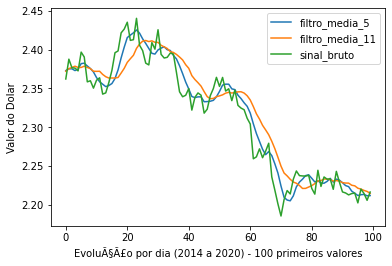

In [6]:
#2-d) Plotar o grÃ¡fico de um trecho de 100 amostras dos dois sinais filtrados
#Plotar o grÃ¡fico sem filtro.
# Nomes dos eixos
eixoy = 'Valor do Dolar'
eixox = 'EvoluÃ§Ã£o por dia (2014 a 2020) - 100 primeiros valores'
filtro.plotar_grafico(eixox, eixoy, y1, y2, vetor_entrada_sinais, 
    **{"filtro_media_5":y1, "filtro_media_11":y2, "sinal_bruto":vetor_entrada_sinais})

In [7]:
#3 - FILTRAGEM GAUSSIANA

#3-a) Gera Filtro Gaussiano de tamanho 5
g_5 = filtro.gera_filtro_gaussiano(5)
#print("Filtro Gaussiano 5 gerado:", g_5)

#3-b) Gera Filtro Gaussiano de tamanho 11
g_11 = filtro.gera_filtro_gaussiano(11)
#print("Filtro Gaussiano 11 gerado:", g_11)

#3-c) Obtenha z1[n] = x[n]*g_5[n] e z2[n] = x[n]*g_11[n]
z1 = filtro.filtra_sinal(vetor_entrada_sinais, g_5)
z2 = filtro.filtra_sinal(vetor_entrada_sinais, g_11)

#Remove sinais de sobra. Necessario somente na convoluÃ§Ã£o ciurcular.
#z1 = filtro.remove_sinais_sobra(len(g_5), z1)
#Remove sinais de sobra
#z2 = filtro.remove_sinais_sobra(len(g_11), z2)

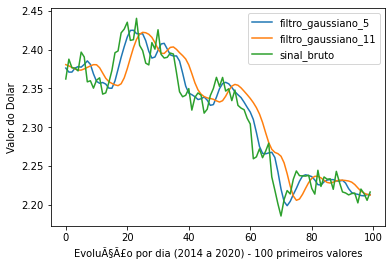

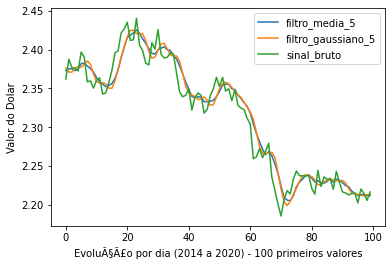

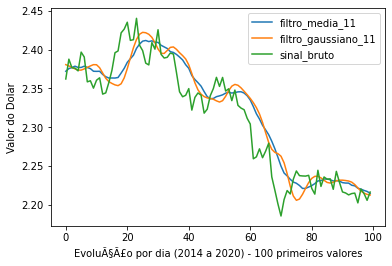

In [8]:
#2-d) Plotar o grÃ¡fico de um trecho de 100 amostras dos dois sinais filtrados
#Plotar o grÃ¡fico sem filtro
# Criei um dicionario pra passar os nomesm que quero plotar no grafico
filtro.plotar_grafico(eixox, eixoy, z1, z2, vetor_entrada_sinais,**{"filtro_gaussiano_5":z1, "filtro_gaussiano_11":z2,
"sinal_bruto":vetor_entrada_sinais})

#4 - ANALISE DOS RESULTADOS
filtro.plotar_grafico(eixox, eixoy, y1, z1, vetor_entrada_sinais,**{"filtro_media_5":y1, "filtro_gaussiano_5":z1, 
"sinal_bruto":vetor_entrada_sinais})
filtro.plotar_grafico(eixox, eixoy, y2, z2, vetor_entrada_sinais,**{"filtro_media_11":y2, "filtro_gaussiano_11":z2, 
"sinal_bruto":vetor_entrada_sinais})

%%